# ONNX Inference Demo

Load the exported Tiny VAD ONNX graph, run it on an arbitrary audio file,
and plot the resulting probability curve together with detected speech segments.



In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import onnxruntime as ort

from vad_distill.config.chunk_config import FRAME_HOP, N_MELS
from vad_distill.config.data_paths import EXPORT_DIR, RAW_DIR
from vad_distill.preprocessing.audio_utils import compute_log_mel, load_audio
from vad_distill.preprocessing.chunking import chunk_fbank_features, reassemble_chunk_predictions



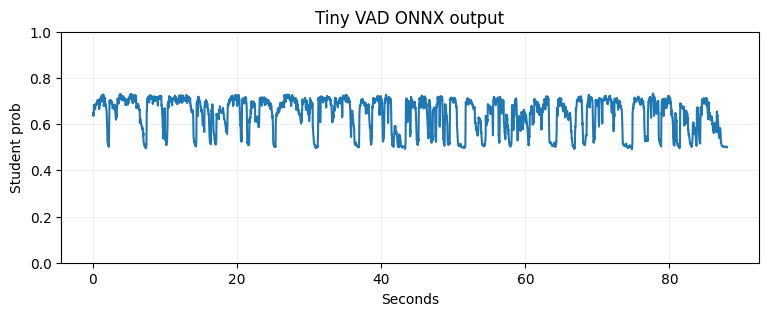

In [4]:
onnx_path = EXPORT_DIR / "tiny_vad.onnx"
audio_path = Path("demo.opus")
assert onnx_path.exists(), "Export the ONNX model first"
assert audio_path.exists(), f"Missing audio: {audio_path}"

session = ort.InferenceSession(str(onnx_path))
wav = load_audio(audio_path)
fbank = compute_log_mel(wav, n_mels=N_MELS)
chunks = chunk_fbank_features(fbank, pad_incomplete=True)
preds = []
for _, chunk in chunks:
    onnx_out = session.run(None, {"mel_features": chunk.astype(np.float32)[None, :, :]})[0]
    preds.append(1.0 / (1.0 + np.exp(-onnx_out.squeeze())))

scores = reassemble_chunk_predictions(chunks, preds)
time_axis = np.arange(len(scores)) * FRAME_HOP
plt.figure(figsize=(9, 3))
plt.plot(time_axis, scores)
plt.xlabel("Seconds")
plt.ylabel("Student prob")
plt.ylim(0, 1)
plt.title("Tiny VAD ONNX output")
plt.grid(alpha=0.2)
plt.show()



In [5]:
threshold = 0.5
binary = scores > threshold
segments = []
start = None
for idx, flag in enumerate(binary):
    if flag and start is None:
        start = idx
    elif not flag and start is not None:
        segments.append((start * FRAME_HOP, idx * FRAME_HOP))
        start = None
if start is not None:
    segments.append((start * FRAME_HOP, len(binary) * FRAME_HOP))

print("Detected segments (first five):")
print(segments[:5])



Detected segments (first five):
[(0.0, 7.28), (7.38, 30.87), (31.0, 31.16), (31.17, 36.85), (36.87, 42.45)]
